In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
sys.path.append('../')
sys.path.append('../util/')
import feedforward_robust as ffr
import ipdb
from util import *

#Read the counter
ctr_file = "counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#Setup - Dataset stuff
dataset, input_shape, num_classes = get_dataset()
x_train_flat, y_train = dataset[0] 
x_test_flat, y_test = dataset[1] 
hidden_sizes = [32,32,32,32,32,32,32]

In [4]:
x_train_flat.shape

(60000, 784)

In [5]:
def plot_singular_values(matrix, idx):
    _, sig, V = np.linalg.svd(matrix)
    plt.plot(range(len(sig)), sig, label = "Layer number %d" %idx)
    plt.legend(loc = 'upper right')
    return sig

In [6]:
def regular_training(config_inp):
    print("Yes using the correct one.")
    eps_train = config_inp['eps_train'] 
    eps_test = config_inp['eps_test'] 
    tensorboard_dir = config_inp['tensorboard_dir'] 
    weights_dir = config_inp['weights_dir']
    load_counter = config_inp['load_counter'] 
    sigma = config_inp['sigma']
    scope_name = config_inp['scope_name']
    
    with tf.variable_scope(scope_name, reuse = tf.AUTO_REUSE) as scope:
        sess = tf.Session()
        logdir = tensorboard_dir + str(counter) + "/non_robust"

        #Create, train and test model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma =sigma)
        logger.info("Created model successfully. Now going to load weights")

        #Restore weights
        weights = tf.trainable_variables()
        saver = tf.train.Saver(weights)
        weights_path = saver.restore(sess, weights_dir + "model_" + str(load_counter) + ".ckpt")

        writer.add_graph(sess.graph)

        loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
        logger.info("----Regular test accuracy and loss ----")
        logger.info((loss_reg, acc_reg))


        with tf.variable_scope("testing_benign") as scope:
            loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
            logger.info("----Regular test accuracy and loss ----")
            logger.info((loss_reg, acc_reg))


        with tf.variable_scope("testing_adversarial") as scope:
            loss_fgsm, acc_fgsm = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False)
            logger.info("----FGSM test accuracy and loss ----")
            logger.info((loss_fgsm, acc_fgsm))
            x_test_flat_adv = model.fgsm_np(sess, x_test_flat, y_test, eps_test)
    return model, sess

In [7]:
def adversarial_training(config):
    eps_train = config['eps_train'] 
    eps_test = config['eps_test'] 
    tensorboard_dir = config['tensorboard_dir'] 
    weights_dir = config['weights_dir']
    load_counter = config['load_counter'] 
    sigma = config['sigma']
    scope_name_rob = config['scope_name']
    sess = tf.Session()
    hidden_sizes = [32,32,32,32,32,32,32]
    
    dataset = ((x_train_flat, y_train), (x_test_flat, y_test))

    with tf.variable_scope(scope_name_rob, reuse = False) as scope:
        logdir = tensorboard_dir + str(counter) + "/robust"
        writer_robust = tf.summary.FileWriter(logdir)
        logger.info("Adversarial Training")
        robust_model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer_robust, scope = scope_name_rob, logger = logger, sigma = sigma)
        sess.run(tf.global_variables_initializer())
        robust_model.adv_fit(sess, x_train_flat, y_train, eps_train, lr = 3e-4, training_epochs = 20)

        print(robust_model.evaluate(sess, x_test_flat, y_test))
        print(robust_model.adv_evaluate(sess, x_test_flat, y_test, eps_test))
    return robust_model, sess

In [8]:
def activation_distance(activation_list):
    diff = []
    diff_norms = []
    for i in range(len(activation_list) - 1):
        difference = activation_list[i+1] - activation_list[i]
        diff.append(difference)
        diff_norms.append(np.linalg.norm(difference)/np.linalg.norm(activation_list[i]))
    return diff, diff_norms

## Regular Training

In [9]:
config = {}
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"

config['load_counter'] = 234
config['sigma'] = tf.nn.relu

config['scope_name'] = "model_non_robust"

In [10]:
config['scope_name']

'model_non_robust'

In [11]:
model_non_robust, sess_non_robust = regular_training(config)

Initialized instance variables of the robust model class
I0829 16:30:29.019833 4529395136 feedforward_robust.py:30] Initialized instance variables of the robust model class
W0829 16:30:29.021157 4529395136 deprecation_wrapper.py:119] From ../feedforward_robust.py:34: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Created placeholders for x and y
I0829 16:30:29.024662 4529395136 feedforward_robust.py:36] Created placeholders for x and y
W0829 16:30:29.027037 4529395136 deprecation_wrapper.py:119] From ../util.py:34: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0829 16:30:29.028053 4529395136 deprecation_wrapper.py:119] From ../util.py:34: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0829 16:30:29.029495 4529395136 deprecation_wrapper.py:119] From ../util.py:36: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0829 16:30:29.048

Yes using the correct one.


Added loss computation to the graph
I0829 16:30:29.224940 4529395136 feedforward_robust.py:45] Added loss computation to the graph
Added accuracy computation to the graph
I0829 16:30:29.232789 4529395136 feedforward_robust.py:49] Added accuracy computation to the graph
Model graph was created
I0829 16:30:29.235784 4529395136 feedforward_robust.py:52] Model graph was created
W0829 16:30:29.237574 4529395136 deprecation_wrapper.py:119] From ../feedforward_robust.py:53: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

Created model successfully. Now going to load weights
I0829 16:30:29.240903 4529395136 <ipython-input-6-e26862baedb0>:18] Created model successfully. Now going to load weights
W0829 16:30:29.261045 4529395136 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a fut

In [12]:
with tf.variable_scope(config['scope_name']) as scope:
    weights_non_robust = model_non_robust.get_weights_np(sess_non_robust)

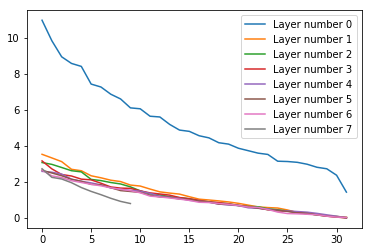

In [13]:
#Original without regularization
sing_vals = []
for (idx, weight_matrix) in enumerate(weights_non_robust):
        sig = plot_singular_values(weight_matrix, idx)
        sing_vals.append(sig)

In [14]:
sing_vals

[array([10.98934  ,  9.849143 ,  8.9571495,  8.589343 ,  8.424989 ,
         7.442756 ,  7.2798185,  6.879962 ,  6.616007 ,  6.1205773,
         6.0696473,  5.6559844,  5.6149917,  5.2019434,  4.8868704,
         4.8151917,  4.571614 ,  4.4537935,  4.1841106,  4.1064925,
         3.8774009,  3.7417672,  3.605185 ,  3.5330877,  3.1569746,
         3.139727 ,  3.0948906,  2.988961 ,  2.8200884,  2.7364967,
         2.3776686,  1.43886  ], dtype=float32),
 array([3.5399613 , 3.3393252 , 3.1339645 , 2.7066133 , 2.6268587 ,
        2.3468897 , 2.2352798 , 2.101153  , 2.025469  , 1.832221  ,
        1.7765919 , 1.6091101 , 1.4537913 , 1.385822  , 1.329209  ,
        1.1839622 , 1.0472189 , 1.0019002 , 0.9513587 , 0.893556  ,
        0.81628394, 0.71710473, 0.6187097 , 0.5800394 , 0.55525225,
        0.4472064 , 0.3030115 , 0.25293425, 0.17364141, 0.11431789,
        0.08316629, 0.04528319], dtype=float32),
 array([3.0823748 , 2.9809802 , 2.8074439 , 2.6283894 , 2.5642107 ,
        2.1463795 

In [15]:
#Regular points
acts = model_non_robust.get_activation(sess_non_robust, x_test_flat)
diff, diff_norm = activation_distance(acts)

#Adversarial points
x_test_flat_adv = model_non_robust.fgsm_np(sess_non_robust, x_test_flat, y_test, config['eps_test'])
acts_adv = model_non_robust.get_activation(sess_non_robust, x_test_flat_adv)
diff_adv, diff_norm_adv = activation_distance(acts_adv)

In [16]:
diff_norm

[1.180735, 1.3017206, 1.2705342, 1.3235074, 1.2170277, 1.2869717]

In [17]:
diff_norm_adv

[1.151944, 1.2491419, 1.2110084, 1.2899554, 1.1872396, 1.3583589]

In [18]:
dphi_dx_test = model_non_robust.get_dphi_dx(sess_non_robust, x_test_flat)[0]

In [19]:
dphi_dx_test[0]

array([-1.70424387e-01, -2.28483647e-01,  2.46494144e-01,  2.72350013e-01,
        4.93438542e-02, -4.51346964e-01, -3.80778432e-01, -1.82161629e-01,
        1.31927043e-01, -1.15903616e-02,  1.28423020e-01, -2.23013625e-01,
       -3.47879678e-01, -4.70310040e-02, -1.87043220e-01, -1.29934892e-01,
        4.66792919e-02, -1.83506712e-01, -3.01369399e-01, -2.52531528e-01,
       -1.75994694e-01, -2.61307538e-01, -1.17210887e-01, -1.61502436e-02,
        2.26399422e-01,  4.14602786e-01,  1.45522626e-02, -2.70412952e-01,
        9.56932902e-02, -2.59628966e-02,  1.48275137e-01,  2.65621506e-02,
       -2.58640409e-01,  4.96143922e-02, -5.84253930e-02, -3.04628044e-01,
       -3.84318054e-01, -7.56812990e-01, -6.46627128e-01,  5.38178027e-01,
        5.89975953e-01,  5.50226092e-01, -5.23123920e-01, -1.36050761e-01,
       -5.23589551e-01, -2.02670023e-01,  2.43016127e-02, -3.74661200e-02,
        4.98666674e-01,  4.94081557e-01, -1.03673317e-01,  4.26361471e-01,
        7.45374709e-02,  

In [20]:
dphi_dx_test_non_robust = dphi_dx_test

In [21]:
np.mean(np.abs(dphi_dx_test_non_robust))

0.7541164

In [22]:
adv_images_fgsm = model_non_robust.fgsm_np(sess_non_robust, x_test_flat, y_test, 0.10)

In [23]:
model_non_robust.evaluate(sess_non_robust, adv_images_fgsm, y_test)

Model was evaluated on benign data
I0829 16:30:31.175179 4529395136 feedforward_robust.py:304] Model was evaluated on benign data


(7.2898045, 0.0383)

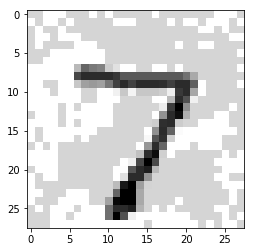

In [24]:
test_image = adv_images_fgsm[0]
two_d = test_image.reshape((28,28))
plt.imshow(two_d, cmap = plt.cm.binary)

In [25]:
diff_fgsm = x_test_flat[0] - adv_images_fgsm[0]

In [26]:
diff_fgsm

array([-0.1       , -0.1       ,  0.1       ,  0.1       ,  0.1       ,
       -0.1       , -0.1       , -0.1       ,  0.1       , -0.1       ,
        0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       ,  0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       ,  0.1       ,
        0.1       ,  0.1       , -0.1       ,  0.1       , -0.1       ,
        0.1       ,  0.1       , -0.1       ,  0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       ,  0.1       ,
        0.1       ,  0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       ,  0.1       , -0.1       ,  0.1       ,  0.1       ,
       -0.1       ,  0.1       ,  0.1       ,  0.1       , -0.1       ,
        0.1       , -0.1       ,  0.1       , -0.1       , -0.1       ,
        0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1 

In [34]:
with tf.variable_scope(config['scope_name'], reuse = tf.AUTO_REUSE) as scope:
    #loss_pgd, acc_pgd = model_non_robust.adv_evaluate(sess_non_robust, x_test_flat, y_test, 0.10, pgd = True, eta=5, num_iter = 20)
    adv_images_pgd = model_non_robust.pgd_adam_np(sess_non_robust, x_test_flat, y_test, eps = 0.1, eta = 0.5, num_iter = 20)

Max difference before projecting
I0829 16:35:07.087713 4529395136 feedforward_robust.py:172] Max difference before projecting
1.0650902
I0829 16:35:07.144890 4529395136 feedforward_robust.py:174] 1.0650902


iteration: 0


Max difference after projecting
I0829 16:35:07.243772 4529395136 feedforward_robust.py:180] Max difference after projecting
0.1
I0829 16:35:07.259273 4529395136 feedforward_robust.py:181] 0.1


loss 17.695671
iteration: 1
loss 17.802794
iteration: 2
loss 17.845243
iteration: 3
loss 17.877304
iteration: 4
loss 17.900145
iteration: 5
loss 17.920713
iteration: 6
loss 17.935984
iteration: 7
loss 17.948181
iteration: 8
loss 17.961987
iteration: 9
loss 17.970802
iteration: 10
loss 17.980690
iteration: 11
loss 17.988468
iteration: 12
loss 17.996168
iteration: 13
loss 18.005625
iteration: 14
loss 18.012705
iteration: 15
loss 18.017000
iteration: 16
loss 18.023447
iteration: 17
loss 18.026829
iteration: 18


This is to confirm that attack does not violate constraints
I0829 16:35:09.356144 4529395136 feedforward_robust.py:197] This is to confirm that attack does not violate constraints
Should be no more than eps
I0829 16:35:09.357871 4529395136 feedforward_robust.py:198] Should be no more than eps


loss 18.031189
iteration: 19
loss 18.036741


0.10000005352730845
I0829 16:35:09.442008 4529395136 feedforward_robust.py:199] 0.10000005352730845


In [29]:
acc_pgd

0.9299

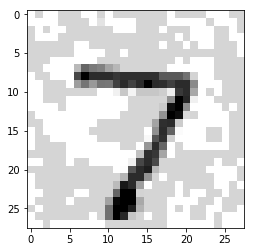

In [35]:
test_image = adv_images_pgd[0]
two_d = test_image.reshape((28,28))
plt.imshow(two_d, cmap = plt.cm.binary)

In [ ]:
difference = test_image - x_test_flat[0]

In [ ]:
max(np.abs(difference))